In [2]:
#!pip install pulser

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


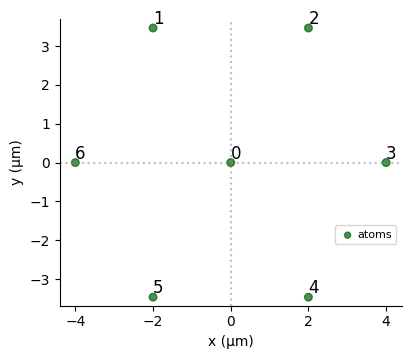

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser.waveforms import ConstantWaveform, InterpolatedWaveform
from pulser.devices import Chadoq2
from scipy.optimize import minimize
from pulser_simulation import QutipEmulator
from scipy.spatial.distance import pdist, squareform

# Define the number of layers
layers = 1

# Qubit register represents number of stations
qubit_register = Register.hexagon(layers)
qubit_register.draw()


In [2]:
np.random.seed(42)

# Define the binary variables Xi for each qubit with random values 0 or 1
Xi = {qubit: random.choice([0, 1]) for qubit in qubit_register.qubits}
#print(Xi)

# Define the weights (distances) between stations
distances = np.random.randint(1, 100, size=(len(Xi), len(Xi)))
np.fill_diagonal(distances, 0)  # Ensure zero distance for self-loops


# Number of binary variables (stations)
N = len(Xi)

# Create an N x N matrix filled with zeros
Q = np.zeros((N, N))

# Calculate the elements of the QUBO matrix Q
for i in range(N):
    for j in range(i, N):
        if i == j:
            Q[i, j] = 1
        else:
            Q[i, j] = distances[i, j] - 0.5 * (distances[i, i] + distances[j, j])
            Q[j, i] = Q[i, j]  # QUBO matrix is symmetric

# Q is now your QUBO matrix

#print(Q)
#len(Q)

In [3]:
print(Xi.values())

dict_values([0, 1, 0, 1, 0, 1, 1])


In [4]:
x = []
for i in Xi.values():
    x.append(i)
x = np.array(x)

In [5]:
#Quick classical check to see if we are going the right direction

bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
costs = []
# this takes exponential time with the dimension of the QUBO
for b in bitstrings:
    z = np.array(list(b), dtype=int)
    alpha = 5
    # Define your desired sum constraint
    c = 10

    # Calculate the sum of binary variables
    sum_x = sum(x)

    # Define the penalty function
    penalty = alpha * (sum_x - c)**2
    cost = np.dot(z, np.dot(Q, z)) + penalty
    costs.append(cost)
zipped = zip(bitstrings, costs)
sort_zipped = sorted(zipped, key=lambda x: x[1])
print(sort_zipped[:3])


[('0000000', 180.0), ('0000001', 181.0), ('0000010', 181.0)]


In [6]:
#Embedding the QUBO on an atomic register
def evaluate_mapping(new_coords, *args):
    """Cost function to minimize. Ideally, the pairwise
    distances are conserved"""
    Q, shape = args
    new_coords = np.reshape(new_coords, shape)
    new_Q = squareform(Chadoq2.interaction_coeff / pdist(new_coords) ** 6.5)
    return np.linalg.norm(new_Q - Q)

shape = (len(Q), 2)
costs = []
np.random.seed(0)
x0 = np.random.random(shape).flatten()
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q, shape),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)
coords = np.reshape(res.x, (len(Q), 2))

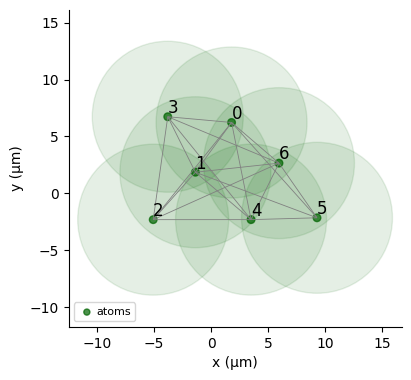

In [7]:
qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True,
)

In [8]:
#simple adiabatic
# We choose a median value between the min and the max
Omega = 0.1*np.median(Q[Q > 0].flatten())
delta_0 = -1  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 6000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

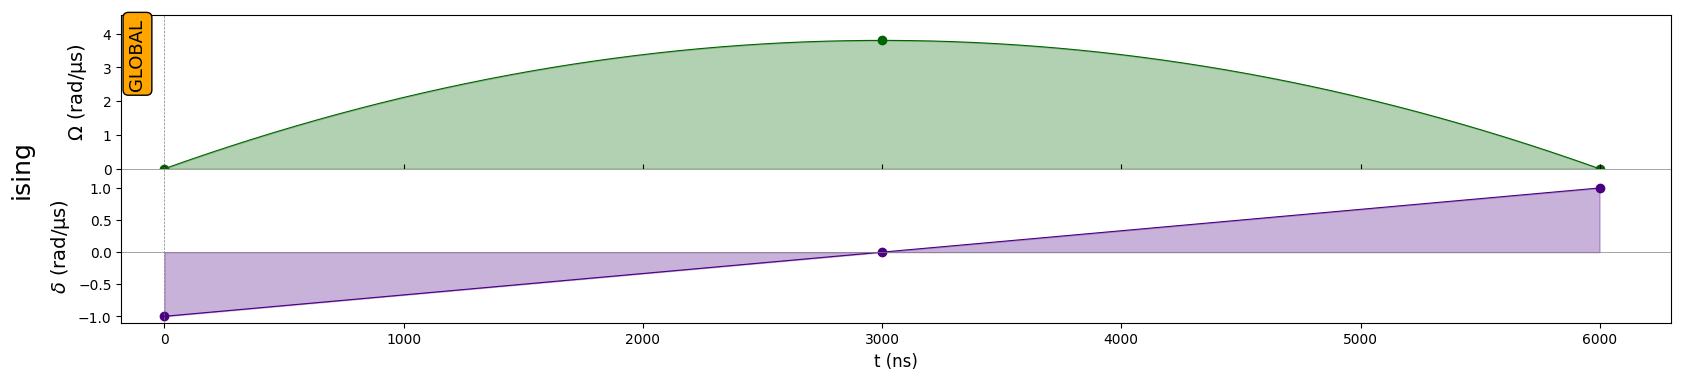

In [9]:
adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")
seq.draw()

In [10]:
from pulser_simulation import Simulation
simul = Simulation(seq)
results = simul.run()
count_dict = results.sample_final_state(N_samples=10000)

/usr/local/lib/python3.10/dist-packages/pulser_simulation/simulation.py:1200: DeprecationWarning: The `Simulation` class is deprecated, use `QutipEmulator.from_sequence` instead.
  warnings.warn(


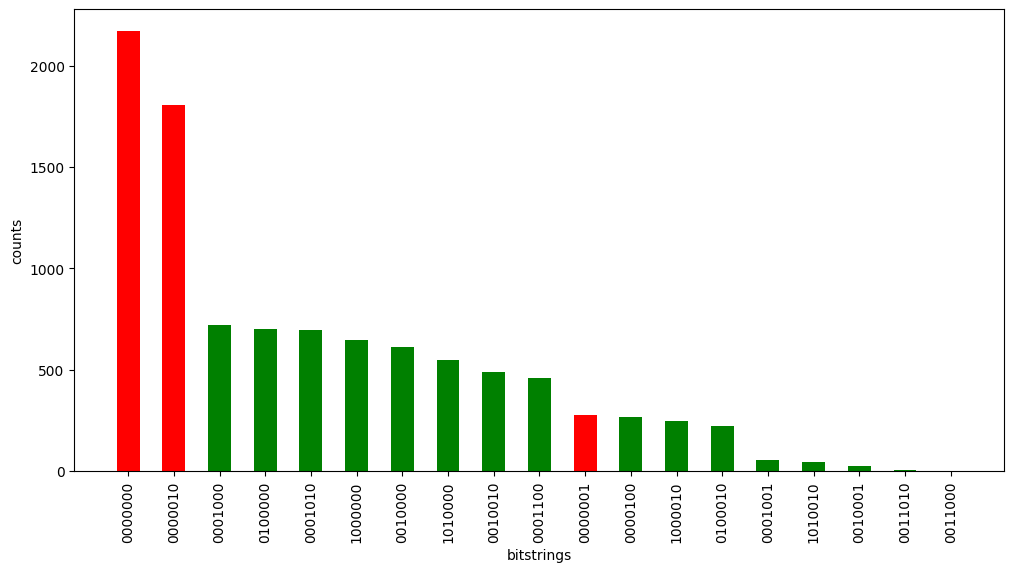

In [12]:
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = ['0000000', '0000001', '0000010']  # QUBO solutions
    color_dict = {key: "r" if key in indexes else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

plot_distribution(count_dict)